In [143]:
from pyspark.sql import SparkSession, functions
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
spark = SparkSession.builder.appName('JobsClassification').getOrCreate()

In [145]:
dataset_train = spark.read.csv(
    path='../../data/jobs/aug_train.csv',
    header=True,
    inferSchema=True
)
dataset_train.show()

+-----------+--------+----------------------+------+--------------------+-------------------+---------------+----------------+----------+------------+--------------+------------+--------------+------+
|enrollee_id|    city|city_development_index|gender| relevent_experience|enrolled_university|education_level|major_discipline|experience|company_size|  company_type|last_new_job|training_hours|target|
+-----------+--------+----------------------+------+--------------------+-------------------+---------------+----------------+----------+------------+--------------+------------+--------------+------+
|       8949|city_103|                  0.92|  Male|Has relevent expe...|      no_enrollment|       Graduate|            STEM|       >20|        null|          null|           1|            36|   1.0|
|      29725| city_40|    0.7759999999999999|  Male|No relevent exper...|      no_enrollment|       Graduate|            STEM|        15|       50-99|       Pvt Ltd|          >4|            47|   

In [146]:
dataset_train.printSchema()

root
 |-- enrollee_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- city_development_index: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- relevent_experience: string (nullable = true)
 |-- enrolled_university: string (nullable = true)
 |-- education_level: string (nullable = true)
 |-- major_discipline: string (nullable = true)
 |-- experience: string (nullable = true)
 |-- company_size: string (nullable = true)
 |-- company_type: string (nullable = true)
 |-- last_new_job: string (nullable = true)
 |-- training_hours: integer (nullable = true)
 |-- target: double (nullable = true)



In [147]:
dataset_train = dataset_train.drop('enrollee_id')
dataset_train.show()

+--------+----------------------+------+--------------------+-------------------+---------------+----------------+----------+------------+--------------+------------+--------------+------+
|    city|city_development_index|gender| relevent_experience|enrolled_university|education_level|major_discipline|experience|company_size|  company_type|last_new_job|training_hours|target|
+--------+----------------------+------+--------------------+-------------------+---------------+----------------+----------+------------+--------------+------------+--------------+------+
|city_103|                  0.92|  Male|Has relevent expe...|      no_enrollment|       Graduate|            STEM|       >20|        null|          null|           1|            36|   1.0|
| city_40|    0.7759999999999999|  Male|No relevent exper...|      no_enrollment|       Graduate|            STEM|        15|       50-99|       Pvt Ltd|          >4|            47|   0.0|
| city_21|                 0.624|  null|No relevent exp

<AxesSubplot:xlabel='target', ylabel='count'>

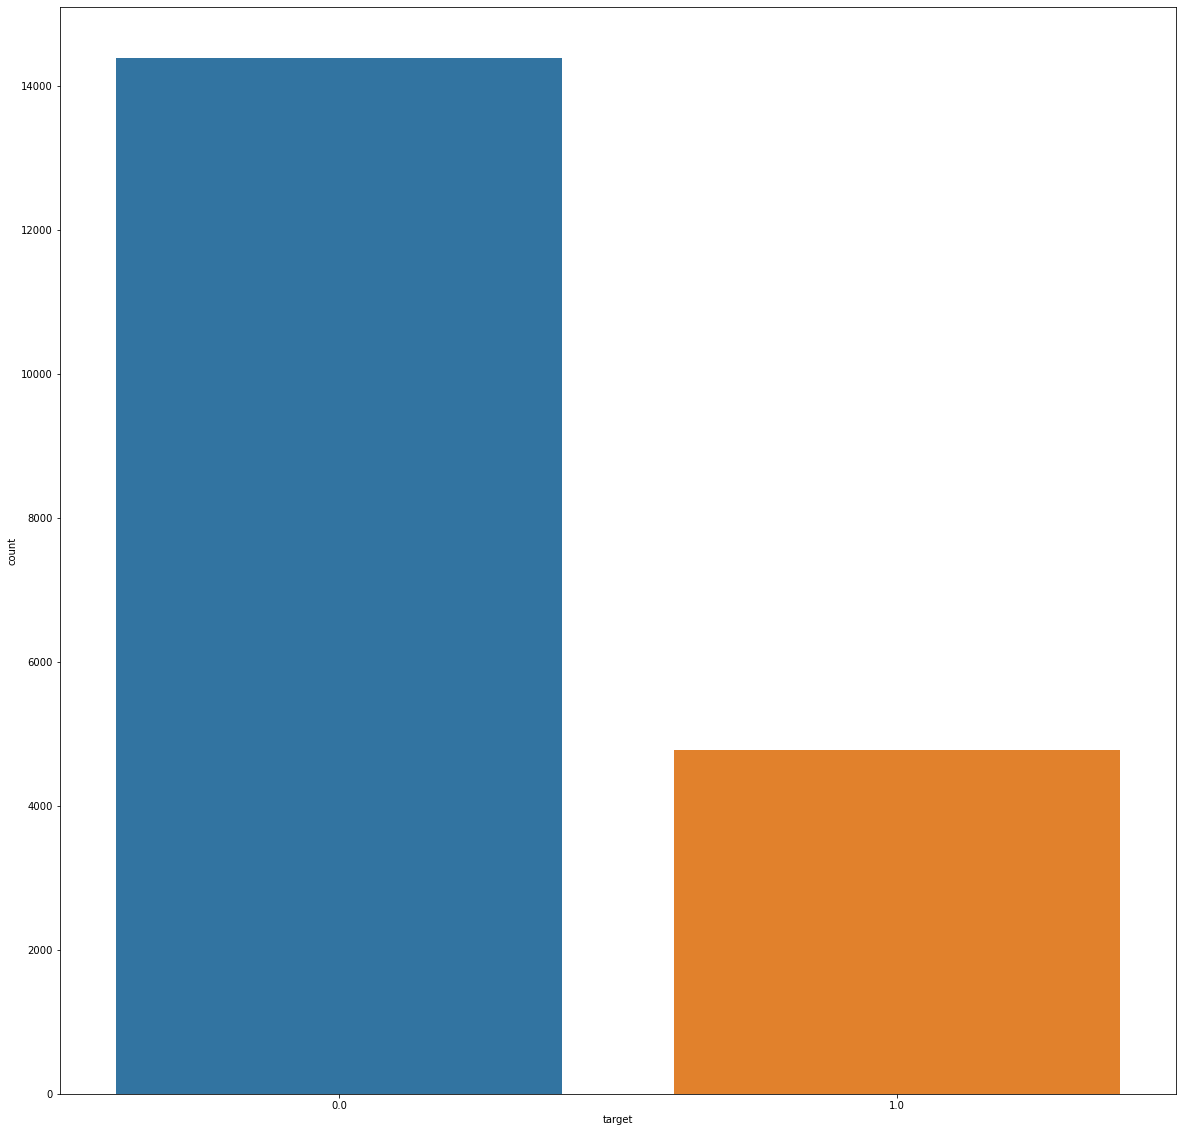

In [148]:
plt.figure(figsize=(20, 20))
sns.countplot(x='target', data=dataset_train.toPandas())

In [149]:
dataset_train.groupby('city').agg(
    functions.count('city').alias('count')
).sort('count', ascending=False).show()


+--------+-----+
|    city|count|
+--------+-----+
|city_103| 4355|
| city_21| 2702|
| city_16| 1533|
|city_114| 1336|
|city_160|  845|
|city_136|  586|
| city_67|  431|
| city_75|  305|
|city_102|  304|
|city_104|  301|
| city_73|  280|
|city_100|  275|
| city_71|  266|
| city_11|  247|
| city_90|  197|
| city_61|  197|
| city_28|  192|
| city_23|  182|
| city_65|  175|
| city_36|  160|
+--------+-----+
only showing top 20 rows



In [150]:
print(f' Quantity of different values City: {dataset_train.select(dataset_train.city).distinct().count()}')
print(
    f' Quantity of different values Experience: {dataset_train.select(dataset_train.relevent_experience).distinct().count()}')
print(
    f' Quantity of different values Enrolled University: {dataset_train.select(dataset_train.enrolled_university).distinct().count()}')
print(
    f' Quantity of different values Education Level: {dataset_train.select(dataset_train.education_level).distinct().count()}')
print(
    f' Quantity of different values Major Discipline: {dataset_train.select(dataset_train.major_discipline).distinct().count()}')
print(
    f' Quantity of different values Company Size: {dataset_train.select(dataset_train.company_size).distinct().count()}')
print(
    f' Quantity of different values Company Type: {dataset_train.select(dataset_train.company_type).distinct().count()}')
print(f' Quantity of different values Last Work: {dataset_train.select(dataset_train.last_new_job).distinct().count()}')


 Quantity of different values City: 123
 Quantity of different values Experience: 2
 Quantity of different values Enrolled University: 4
 Quantity of different values Education Level: 6
 Quantity of different values Major Discipline: 7
 Quantity of different values Company Size: 9
 Quantity of different values Company Type: 7
 Quantity of different values Last Work: 7


In [151]:
target_encoder = StringIndexer(inputCol='target', outputCol='targetEncoder')
city_encoder = StringIndexer(inputCol='city', outputCol='cityEncoder')
gender_encoder = StringIndexer(inputCol='gender', outputCol='genderEncoder')
exp_encoder = StringIndexer(inputCol='relevent_experience', outputCol='expEncoder')
uny_encoder = StringIndexer(inputCol='enrolled_university', outputCol='unyEncoder')
edu_encoder = StringIndexer(inputCol='education_level', outputCol='eduEncoder')
dis_encoder = StringIndexer(inputCol='major_discipline', outputCol='disEncoder')
c_size_encoder = StringIndexer(inputCol='company_size', outputCol='cSizeEncoder')
c_type_encoder = StringIndexer(inputCol='company_type', outputCol='cTypeEncoder')
l_job_encoder = StringIndexer(inputCol='last_new_job', outputCol='lJobEncoder')

In [152]:
features_encoder = VectorAssembler(inputCols=['city_development_index',
                                              'training_hours',
                                              #'cityEncoder',
                                              #'genderEncoder',
                                              'expEncoder',
                                              #'unyEncoder',
                                              #'eduEncoder',
                                              #'disEncoder',
                                              #'cSizeEncoder',
                                              #'cTypeEncoder',
                                              #'lJobEncoder',
                                              ],
                                   outputCol='features')

In [153]:
decision_model = DecisionTreeClassifier(labelCol='targetEncoder',
                                        featuresCol='features',
                                        maxDepth=10, maxBins=32)

In [154]:
pipeline = Pipeline(
    stages=[
        target_encoder,
        city_encoder,
        gender_encoder,
        exp_encoder,
        uny_encoder,
        edu_encoder,
        dis_encoder,
        c_size_encoder,
        c_type_encoder,
        l_job_encoder,
        features_encoder
    ]
)

In [155]:
pipeline_encoder = pipeline.fit(dataset_train)
dataset_encoder = pipeline_encoder.transform(dataset_train)

In [156]:
dataset_encoder.printSchema()

root
 |-- city: string (nullable = true)
 |-- city_development_index: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- relevent_experience: string (nullable = true)
 |-- enrolled_university: string (nullable = true)
 |-- education_level: string (nullable = true)
 |-- major_discipline: string (nullable = true)
 |-- experience: string (nullable = true)
 |-- company_size: string (nullable = true)
 |-- company_type: string (nullable = true)
 |-- last_new_job: string (nullable = true)
 |-- training_hours: integer (nullable = true)
 |-- target: double (nullable = true)
 |-- targetEncoder: double (nullable = false)
 |-- cityEncoder: double (nullable = false)
 |-- genderEncoder: double (nullable = false)
 |-- expEncoder: double (nullable = false)
 |-- unyEncoder: double (nullable = false)
 |-- eduEncoder: double (nullable = false)
 |-- disEncoder: double (nullable = false)
 |-- cSizeEncoder: double (nullable = false)
 |-- cTypeEncoder: double (nullable = false)
 |-- lJobEnco

In [157]:
dataset_encoder.select('features').show()

+--------------------+
|            features|
+--------------------+
|     [0.92,36.0,0.0]|
|[0.77599999999999...|
|    [0.624,83.0,1.0]|
|    [0.789,52.0,1.0]|
|     [0.767,8.0,0.0]|
|    [0.764,24.0,0.0]|
|     [0.92,24.0,0.0]|
|    [0.762,18.0,0.0]|
|     [0.92,46.0,0.0]|
|    [0.92,123.0,0.0]|
|    [0.624,32.0,1.0]|
|    [0.92,108.0,0.0]|
|[0.91299999999999...|
|    [0.624,24.0,1.0]|
|    [0.624,26.0,1.0]|
|[0.92599999999999...|
|    [0.92,106.0,0.0]|
|     [0.624,7.0,0.0]|
|    [0.624,23.0,0.0]|
|[0.82700000000000...|
+--------------------+
only showing top 20 rows



In [158]:
train, test = dataset_encoder.randomSplit([0.7, 0.3], seed=2021)

In [159]:
tree_model = decision_model.fit(dataset_encoder)
predictions = tree_model.transform(dataset_encoder)

In [160]:
predictions.select('target', 'prediction').show()

+------+----------+
|target|prediction|
+------+----------+
|   1.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   1.0|       0.0|
|   0.0|       0.0|
|   1.0|       0.0|
|   0.0|       0.0|
|   1.0|       0.0|
|   1.0|       0.0|
|   0.0|       0.0|
|   1.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       1.0|
|   0.0|       1.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       1.0|
|   1.0|       1.0|
|   1.0|       0.0|
+------+----------+
only showing top 20 rows



In [161]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='target')
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6465237791292348
